### Pokestop classifier
* 한림대학교 딥러닝이해및응용(7210231) 과목 자료입니다
* Hallym Univ. 
* Deeplearning
* 2018/11/13

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.python.framework import ops
from dd_nnutil_hallym3 import *
import random
import time

!pip install pillow

결과 저장을 위한 폴더 생성

In [3]:
import os
directory_out = 'out'
if not os.path.exists(directory_out):
    os.makedirs(directory_out)

### Dataset 업로드 확인

!ls
!pwd

In [4]:
!dir

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: E089-924C

 C:\Users\Hyejoo\710231\04_Casestudy\02_Pokestop 디렉터리

2018-11-28  오전 12:44    <DIR>          .
2018-11-28  오전 12:44    <DIR>          ..
2018-11-27  오후 12:46    <DIR>          .ipynb_checkpoints
2018-11-28  오전 12:44           460,171 7210231_2018Nov_pokestop_v1.ipynb
2018-11-28  오전 12:16    <DIR>          data
2018-11-22  오후 12:44             4,829 dd_nnutil_hallym3.py
2018-11-27  오후 12:47    <DIR>          out
2018-11-27  오후 12:47    <DIR>          __pycache__
               2개 파일             465,000 바이트
               6개 디렉터리  48,750,301,184 바이트 남음


In [5]:
folder1 ="./data"

In [6]:
import os
sorted(os.listdir(folder1))

['0_crop',
 '1_crop',
 '2_crop',
 '3_crop',
 '4_crop',
 '5_crop',
 '6_crop',
 '7_crop',
 '8_crop',
 '9_crop']

예상되는 출력:

---
['0_crop', '1_crop', '2_crop', '3_crop', '4_crop', '5_crop', '6_crop', '7_crop', '8_crop', '9crop']





### Data 검토해보기

Data의 종류. 현재는 10가지의 data를 사용하므로 10을 사용합니다.

In [7]:
len(os.listdir(folder1))

10

In [8]:
nclasses = 10

그려볼 이미지 index. 아래의 숫자를 바꾸어 가며 아래 cell에 그림이 제대로 표시가 되는지 확인해보세요.
**최종적으로는 직접 생성한 이미지가 display되도록 idx를 설정하세요**

In [9]:
idx= 35

class 0 -- 200
class 1 -- 200
class 2 -- 200
class 3 -- 200
class 4 -- 200
class 5 -- 200
class 6 -- 200
class 7 -- 200
class 8 -- 200
class 9 -- 200


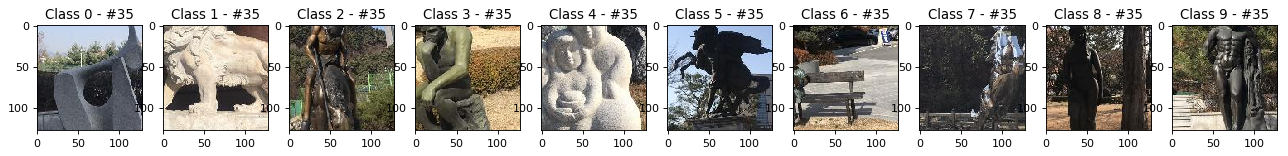

In [10]:
fig, ax = plt.subplots(figsize=(20, 10), dpi=80)
for i in range(nclasses):
    img1, ntot = load_image_test(folder=folder1, img_class=i, suffix='_crop', idx=idx)
    print('class', i, '--', ntot)
    img1c = centered_crop(img1, output_side_length=128)
    plt.subplot(1,nclasses,i+1)
    plt.title('Class {} - #{}'.format(i, idx))
    plt.imshow(img1c)

### Hyper-parameters

In [11]:
learning_rate=0.005
num_epochs=200 #50
minibatch_size=32

### 본격적으로 시작 - Data 로드 하기

In [12]:
X_train, Y_train_orig, X_test, Y_test_orig = \
    load_dataset(folder=folder1, nclasses=nclasses, suffix = '_crop')

./data/0_crop/*.JPG --> (200,)
./data/1_crop/*.JPG --> (200,)
./data/2_crop/*.JPG --> (200,)
./data/3_crop/*.JPG --> (200,)
./data/4_crop/*.JPG --> (200,)
./data/5_crop/*.JPG --> (200,)
./data/6_crop/*.JPG --> (200,)
./data/7_crop/*.JPG --> (200,)
./data/8_crop/*.JPG --> (200,)
./data/9_crop/*.JPG --> (200,)


In [13]:
print(X_train.shape)
print(Y_train_orig.shape)

(1400, 128, 128, 3)
(1400,)


일반 숫자를 one-hot encoding으로 !

In [14]:
Y_train = convert_to_one_hot(Y_train_orig, nclasses).T
Y_test = convert_to_one_hot(Y_test_orig, nclasses).T

Data shape 살펴보기. Dimension을 살펴보세요

In [15]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1400
number of test examples = 600
X_train shape: (1400, 128, 128, 3)
Y_train shape: (1400, 10)
X_test shape: (600, 128, 128, 3)
Y_test shape: (600, 10)


Text(0.5,1,'idx #25-- class #[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]')

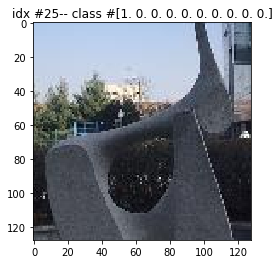

In [16]:
# display images
idx1 = 25
x1 = X_train[idx1]
y1 = Y_train[idx1]

plt.figure()
plt.imshow(x1)
plt.title('idx #{}-- class #{}'.format(idx1, y1))

위의 idx1 값을 바꾸어보며 테스트해보세요.  **마찬가지로 본인들의 사진이 나오도록 최종 idx1 값을 설정해보세요**

### Placeholders 만들기

In [17]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])

    return X, Y

### Parameter 초기화 하기
* W1, W2의 크기, 갯수를 원하는 대로 변경하세요. 
* W3, W4.. 등이 필요한 경우 자유롭게 넣어보세요

In [18]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [3, 3, 3, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    #W3 = ...  #필요하면 추가해보세요
    parameters = {"W1": W1,
                  "W2": W2}

    return parameters

### Forward propagation
* 아래는 다음과 같은 ConvNet을 구현한 것입니다. 자유롭게 stride, pooling의 ksize 변경해보세요.
```
CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FC
```
* CONV2D -> RELU -> MAXPOOL 을 하나의 덩어리로 생각하면 좋습니다



In [19]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')

    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')

    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None"
    Z3 = tf.contrib.layers.fully_connected(P2, nclasses, activation_fn=None)
    Y_hat = Z3
   
    return Y_hat

### Cost 계산하기

In [20]:
def compute_cost(Y_hat, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Y_hat, labels = Y))
    #cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Y_hat, labels=Y))
    return cost

### Model 
지금까지 함수로 만들었던 기능들을 불러 만들어 네트워크를 구성합니다

In [21]:
(m, n_H0, n_W0, n_C0) = X_train.shape
n_y = Y_train.shape[1]

In [22]:
ops.reset_default_graph()
X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
parameters = initialize_parameters()
Y_hat = forward_propagation(X, parameters)
cost = compute_cost(Y_hat, Y)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Start the session to compute the tensorflow graph

In [23]:
print_cost = True

In [24]:
vcosts = []  # cost를 저장할 빈 list
vtime = [] # 연산시간을 기록할 빈 list

In [25]:
# Reset the graph
#tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [26]:
seed = 0
sess.run(tf.global_variables_initializer())
# Do the training loop
for epoch in range(num_epochs):

    minibatch_cost = 0.
    num_minibatches = int(m / minibatch_size)  # number of minibatches of size minibatch_size in the train set
    seed = seed + 1
    minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed=seed)

    for minibatch in minibatches:
        # Select a minibatch
        (minibatch_X, minibatch_Y) = minibatch
        # IMPORTANT: The line that runs the graph on a minibatch.
        # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).

        #_, temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
        t0 = time.time()
        sess.run(optimizer, feed_dict={X: minibatch_X, Y: minibatch_Y})
        t_elapsed = time.time() - t0
        vtime.append(t_elapsed) # 시간을 측정하고 이를 list에 저장함 (append)

        temp_cost = sess.run(cost, feed_dict={X: minibatch_X, Y: minibatch_Y})

        minibatch_cost += temp_cost / num_minibatches

    # Print the cost every epoch
    if print_cost == True and epoch % 5 == 0:
        print("Cost after epoch {}\t{}".format(epoch, minibatch_cost))

    vcosts.append(minibatch_cost)

Cost after epoch 0	1.6287036274754723
Cost after epoch 5	0.010123854576133538
Cost after epoch 10	0.0013788845071969768
Cost after epoch 15	0.0006397282237696006
Cost after epoch 20	0.00036213405211699785
Cost after epoch 25	0.0002391164670011359
Cost after epoch 30	0.00016641457528579807
Cost after epoch 35	0.00012141516700192072
Cost after epoch 40	9.203032992487816e-05
Cost after epoch 45	7.15933674655389e-05
Cost after epoch 50	5.5836543799878824e-05
Cost after epoch 55	4.5441935071721687e-05
Cost after epoch 60	3.7386961721072e-05
Cost after epoch 65	3.0261522254498464e-05
Cost after epoch 70	2.5345168397020746e-05
Cost after epoch 75	2.1103756067574536e-05
Cost after epoch 80	1.7986298141908646e-05
Cost after epoch 85	1.510412873760161e-05
Cost after epoch 90	1.2998268577448892e-05
Cost after epoch 95	1.1050524224544436e-05
Cost after epoch 100	9.53988310991621e-06
Cost after epoch 105	8.220298041599795e-06
Cost after epoch 110	7.061954296088601e-06
Cost after epoch 115	6.0859740

In [27]:
correct_prediction = tf.equal(tf.argmax(Y_hat, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

nb_test = -1#500
train_accuracy = accuracy.eval({X: X_train[:nb_test], Y: Y_train[:nb_test]})
test_accuracy = accuracy.eval({X: X_test[:nb_test], Y: Y_test[:nb_test]})
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

print("Mean time to train for each batch: {:.3f} sec / batch size : {}".format(np.mean(vtime), minibatch_size))


Train Accuracy: 1.0
Test Accuracy: 1.0
Mean time to train for each batch: 0.356 sec / batch size : 32


학습된 모델로 예측해보기 (correct predictions)
* 10개 테스트 해보기 --> 자유롭게 원하는 대로 변경하여 테스트 해보세요

In [28]:
ntest = -1
if ntest==-1:
    ntest = X_test.shape[0]
print('number of test images: {}'.format(ntest))

number of test images: 600


In [29]:
for j in range(0,ntest):
    # Get one and predict
    if ntest == X_test.shape[0]:
        r = j
    else:
        r = random.randint(0, X_test.shape[0] - 1)
    #print('Picked {} / {}'.format(r, X_test.shape[0]))
    
    v1 = sess.run(tf.argmax(Y_test[r:r+1], 1))
    t0 = time.time()
    #v2 = sess.run(tf.argmax(Y_hat, 1), feed_dict={X: X_test[r:r+1]})
    v2raw = sess.run(Y_hat, feed_dict={X: X_test[r:r+1]})
    v2 = np.argmax(v2raw)
    #print(v2raw, '----', v2)    
    t_elapsed = time.time() - t0
    bok = (v1 == v2)
    str1 = '#{}, Label: {}, Pred: {}, {}, Time : {:.3f} sec'.format(r, v1, v2,bok, t_elapsed)
    if ntest < X_test.shape[0]:
        print(str1)
    else:
        if j % 100 ==0:
            print(str1)
    if not bok:
        str2 = '#{}, Label: {}, Pred: {} --> {}\n{}'.format(r, v1, v2, bok, v2raw)
    else:
        str2 = '#{}, Label: {}, Pred: {} --> {}'.format(r, v1, v2, bok)
    #print(str2)
    plt.figure()
    plt.imshow(X_test[r])
    
    plt.title(str2)
    
    
    if not bok:
        filename_img = '{}/image_test_{}_fail.png'.format(directory_out, j)
    else:
        filename_img = '{}/image_test_{}.png'.format(directory_out, j)
    plt.savefig(filename_img)
    plt.close()



#0, Label: [0], Pred: 0, [ True], Time : 0.010 sec
#100, Label: [1], Pred: 1, [ True], Time : 0.004 sec
#200, Label: [3], Pred: 3, [ True], Time : 0.004 sec
#300, Label: [5], Pred: 5, [ True], Time : 0.004 sec
#400, Label: [6], Pred: 6, [ True], Time : 0.004 sec
#500, Label: [8], Pred: 8, [ True], Time : 0.004 sec


분류가 잘된 예, 잘못된 예 각각 10가지 이상을 찾아서, 보고서에 제출하세요

###  Cost 그려보기

Text(0.5,1,'Learning rate =0.005')

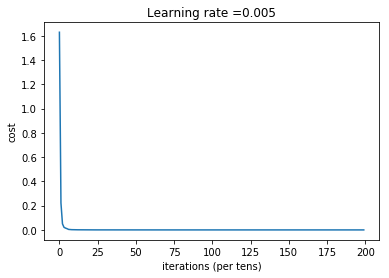

In [30]:
plt.figure()
plt.plot(np.squeeze(vcosts))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(learning_rate))

Cost 의 초반부 확대해서 그려보기

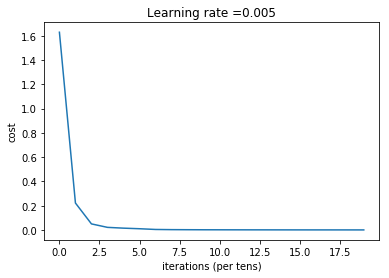

In [31]:
plt.figure()
plt.plot(np.squeeze(vcosts[:20]))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

In [32]:
#sess.close()